This notebook contains the CEFLANN model, as implemented in the study "A hybrid stock trading framework integrating technical analysis with machine learning" (Dash & Dash, 2016)

In [19]:
# Imported python libraries
# To import, run "conda install -c conda-forge <package1> <package2>" in the Anaconda prompt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
from scipy import linalg

In [20]:
# Function to load NVIDIA data from exported files
def load_nvidia_data():

    # Loads CSV data
    technical_data = pd.read_csv('nvidia_technical_data.csv', index_col=0, parse_dates=True, date_format='%Y-%m-%d')
    normalized_data = pd.read_csv('nvidia_normalized_data.csv', index_col=0, parse_dates=True, date_format='%Y-%m-%d')
    
    # Loads NumPy arrays for training and testing
    X_train = np.load('nvidia_X_train.npy')
    y_train = np.load('nvidia_y_train.npy')
    X_test = np.load('nvidia_X_test.npy')
    y_test = np.load('nvidia_y_test.npy')
    
    # Loads latest info
    with open('nvidia_info.txt', 'r') as f:
        latest_info = f.read().split(',')
        latest_date = latest_info[0]
        latest_close = float(latest_info[1])
    
    return {
        'technical_data': technical_data,
        'normalized_data': normalized_data,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'latest_date': latest_date,
        'latest_close': latest_close
    }

# Loads the data
nvidia_data = load_nvidia_data()
print(f"Data loaded successfully. Latest date: {nvidia_data['latest_date']}")
print(f"Latest NVIDIA close price: ${nvidia_data['latest_close']:.2f}")
print(f"Training data shape: X={nvidia_data['X_train'].shape}, y={nvidia_data['y_train'].shape}")
print(f"Testing data shape: X={nvidia_data['X_test'].shape}, y={nvidia_data['y_test'].shape}")

Data loaded successfully. Latest date: 2025-03-13 00:00:00
Latest NVIDIA close price: $115.58
Training data shape: X=(1032, 6), y=(1032,)
Testing data shape: X=(259, 6), y=(259,)


In [21]:
# This class implements the CEFLANN model with ELM learning
class CEFLANN:
    """
    Computational Efficient Functional Link Artificial Neural Network
    
    This implementation follows the paper "A hybrid stock trading framework integrating 
    technical analysis with machine learning techniques" by Dash & Dash (2016)
    """
    
    def __init__(self, expansion_order=5, regularization=0.01):
        """
        Parameters:
        -----------
        expansion_order(int) : The order of expansion for the functional expansion block
        regularization(float) : Regularization parameter for the ELM learning
        """
        self.expansion_order = expansion_order
        self.regularization = regularization
        self.output_weights = None
        self.expansion_params = None
        
    def _functional_expansion(self, X):
        """
        Parameters:
        -----------
        X : Input feature matrix with shape (n_samples, n_features)
            
        Returns:
        --------
        expanded_X : Expanded input pattern array
        """
        n_samples, n_features = X.shape
        
        # Number of expanded features = original features + expansion order
        n_expanded = n_features + self.expansion_order
        
        # Initializes the expanded feature matrix
        expanded_X = np.zeros((n_samples, n_expanded))
        expanded_X[:, :n_features] = X
        
        
        if self.expansion_params is None:
            # For each order i, initializes parameters a_i0 and a_ij (j is from 1 to n_features)
            self.expansion_params = []
            for i in range(self.expansion_order):
                # Initialize bias term a_i0
                a_i0 = np.random.uniform(-1, 1)
                
                # Initialize weights a_ij for each feature
                a_ij = np.random.uniform(-1, 1, size=n_features)
                
                self.expansion_params.append((a_i0, a_ij))
        
        # Applies functional expansion for each order
        for i in range(self.expansion_order):
            a_i0, a_ij = self.expansion_params[i]
            
            # Calculates weighted sum of input features
            weighted_sum = a_i0 + np.dot(X, a_ij)
            
            # Applies a tanh activation function
            expanded_X[:, n_features + i] = np.tanh(weighted_sum)
            
        return expanded_X
    
    def fit(self, X, y):
        """
        Parameters:
        -----------
        X : Training feature matrix of shape (n_samples, n_features)
        y : Target values array of shape (n_samples,)
            
        Returns:
        --------
        self : Returns self
        """
        # Applies functional expansion to transform input features
        expanded_X = self._functional_expansion(X)
        
        # Adds the bias to the expanded input
        n_samples = expanded_X.shape[0]
        bias_col = np.ones((n_samples, 1))
        M = np.hstack((bias_col, expanded_X))
        
        # Uses regularized least squares (Ridge Regression) for output weights        
        n_cols = M.shape[1]
        MtM = np.dot(M.T, M)
        reg_term = self.regularization * np.eye(n_cols)
        inverse_term = np.linalg.inv(MtM + reg_term)
        MP_inverse = np.dot(inverse_term, M.T)
        
        # Calculates output weights
        self.output_weights = np.dot(MP_inverse, y)
        
        return self
    
    def predict(self, X):
        """
        Parameters:
        -----------
        X : Test feature matrix of shape (n_samples, n_features)
            
        Returns:
        --------
        y_pred : Array of predicted values
        """
        # Applies functional expansion to transform input features
        expanded_X = self._functional_expansion(X)
        
        # Adds bias to expanded input
        n_samples = expanded_X.shape[0]
        bias_col = np.ones((n_samples, 1))
        M = np.hstack((bias_col, expanded_X))
        
        y_pred = np.dot(M, self.output_weights)
        
        return y_pred
    
    def evaluate(self, X, y):
        """
        Parameters:
        -----------
        X : Test feature matrix array
        y : Target values array
            
        Returns:
        --------
        mse : Mean squared error
        """
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        return mse

In [22]:
# Trains the model on the training dataset
def train_model(X_train, y_train, expansion_order=5, regularization=0.01):
    """
    Parameters:
    -----------
    X_train : Training features
    y_train : Training targets
    expansion_order : Order of expansion for functional expansion block
    regularization : Regularization parameter for ELM learning
    
    Returns:
    --------
    trained_model : Trained CEFLANN model
    training_time : Time taken to train the model
    """
    model = CEFLANN(expansion_order=expansion_order, regularization=regularization)
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    return model, training_time

# Tests the model on the test dataset
def evaluate_model(model, X_test, y_test, technical_data):
    """
    Parameters:
    -----------
    model : Trained CEFLANN model
    X_test : Test features
    y_test : Test targets
    technical_data : Technical indicators dataframe
    
    Returns:
    --------
    Dictionary of evaluation metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Trend accuracy metrics
    actual_trend = np.where(np.diff(y_test) > 0, 1, 0)
    pred_trend = np.where(np.diff(y_pred) > 0, 1, 0)
    trend_accuracy = np.mean(actual_trend == pred_trend)
    
    # Create a result dictionary
    evaluation_results = {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'trend_accuracy': trend_accuracy,
        'predictions': y_pred,
        'actuals': y_test
    }
    
    return evaluation_results


In [23]:
# Shows a plot of the predicted values vs. the actual values
def visualize_model_predictions(evaluation_results, test_dates):
    """
    Parameters:
    -----------
    evaluation_results : Model evaluation results
    test_dates : Test date array
    """
    plt.figure(figsize=(14, 7))
    
    # Create a subplot for predictions vs actuals
    plt.subplot(2, 1, 1)
    plt.plot(test_dates, evaluation_results['actuals'], label='Actual', color='blue')
    plt.plot(test_dates, evaluation_results['predictions'], label='Predicted', color='red', linestyle='--')
    plt.title('CEFLANN Model Predictions vs Actual Trading Signals')
    plt.ylabel('Trading Signal [0-1]')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Create a subplot for prediction error
    plt.subplot(2, 1, 2)
    error = evaluation_results['predictions'] - evaluation_results['actuals']
    plt.plot(test_dates, error, color='green')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Prediction Error')
    plt.ylabel('Error')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Loading NVIDIA data...

Training untuned CEFLANN model with parameters:
  - Expansion Order: 5
  - Regularization: 0.01
Model training completed in 0.0007 seconds

Evaluating model performance...
Mean Squared Error (MSE): 0.175356
Root Mean Squared Error (RMSE): 0.418755
R-squared: -0.515668
Trend Prediction Accuracy: 62.79%


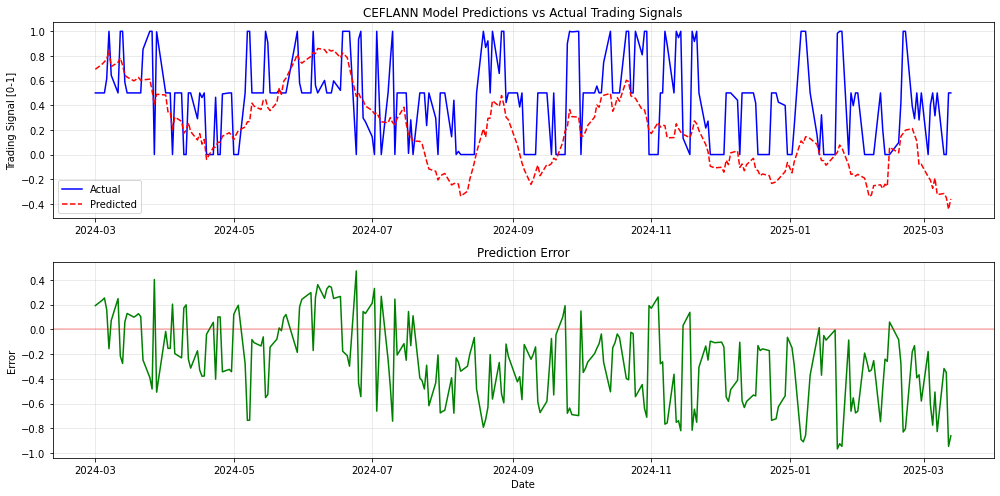

In [24]:
print("Loading NVIDIA data...")
data = load_nvidia_data()
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
technical_data = data['technical_data']

# Default parameters for untuned model
expansion_order = 5
regularization = 0.01

print(f"\nTraining untuned CEFLANN model with parameters:")
print(f"  - Expansion Order: {expansion_order}")
print(f"  - Regularization: {regularization}")

# Train the model
model, training_time = train_model(X_train, y_train, expansion_order=expansion_order, regularization=regularization)
print(f"Model training completed in {training_time:.4f} seconds")

# Evaluate model
print("\nEvaluating model performance...")
evaluation_results = evaluate_model(model, X_test, y_test, technical_data)
print(f"Mean Squared Error (MSE): {evaluation_results['mse']:.6f}") 
print(f"Root Mean Squared Error (RMSE): {evaluation_results['rmse']:.6f}")
print(f"R-squared: {evaluation_results['r2']:.6f}")
print(f"Trend Prediction Accuracy: {evaluation_results['trend_accuracy']*100:.2f}%")
    
# Extract test dates
test_start = len(technical_data) - len(X_test)
test_dates = technical_data.index[test_start:test_start + len(X_test)]
    
# Visualize predictions
visualize_model_predictions(evaluation_results, test_dates)